In [1]:
# SOURCE: https://notebooks.azure.com/Microsoft/libraries/samples/html/Discover%20Sentiments%20in%20Tweets.ipynb
import os
import pandas as pd

# Returns current working directory of a process.
dirname = os.getcwd()

# Download, read, and display .csv data
!curl -L -o mydatafile.csv http://azuremlsamples.azureml.net/templatedata/Text%20-%20Input.csv
mydata = pd.read_csv('mydatafile.csv', header=0)
print(mydata.shape)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.8M  100 11.8M    0     0  18.0M      0 --:--:-- --:--:-- --:--:-- 18.1M
(160000, 2)


In [2]:
# use 10000 for testing
mydata = mydata[:10000]
mydata.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [3]:
import re

#clean data
def clean_text(mystring):
    mystring = re.sub(r"@\w+", "", mystring) #remove twitter handle
    mystring = re.sub(r"\d", "",   mystring) #remove numbers
    mystring = re.sub(r"_+", "",   mystring) #remove consecutive underscores
    mystring = mystring.lower()              #transform to lowercase
    
    return mystring.strip()

mydata["tweet_text_cleaned"] = mydata.tweet_text.apply(clean_text)

In [4]:
# Tokenize the data - divides a string into substrings by splitting on the specified string
from nltk.tokenize import RegexpTokenizer
preprocessed = [" ".join(RegexpTokenizer(r'\w+').\
                         tokenize(mydata.tweet_text_cleaned[idx])) \
                for idx in mydata.index]

In [5]:
# Widely used tool for the analysis of high-dimensional data as it automatically extracts sparse and meaningful 
# features from a set of nonnegative data vector.
# value of tf-idf reflects the number times a word appears in the document 
# after adjusting for the frequency of the word in the corpus.

# Convert a collection of raw documents to a matrix of TF-IDF features.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 

In [6]:
custom_stop_words = []
my_stop_words     = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

vectorizer = TfidfVectorizer(min_df = 1, ngram_range = (1,1),
                            stop_words = my_stop_words)

tfidf = vectorizer.fit_transform(preprocessed)
print("Created document-term matrix of size {} x {}".format(*tfidf.shape[:2]))

Created document-term matrix of size 10000 x 13379


In [7]:
from sklearn import decomposition
import numpy as np

nmf = decomposition.NMF(init = 'nndsvd', n_components = 3, max_iter = 200)
W   = nmf.fit_transform(tfidf)
H   = nmf.components_

print("Generated factor W of size {} and factor H of size {}".format(W.shape, H.shape))

Generated factor W of size (10000, 3) and factor H of size (3, 13379)


In [8]:
feature_names = vectorizer.get_feature_names()
n_top_words = 10

# print top words in each topic
for topic_idx, topic in enumerate(H):
    print("Topic #{}:".format(topic_idx))
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()


Topic #0:
good day work just today morning going like night really

Topic #1:
quot love http just com know amp new like best

Topic #2:
thanks following ff lol got haha great hey hope follow



In [9]:
!pip install --upgrade pip
!pip install wordcloud~=1.2.1

Requirement already up-to-date: pip in /home/nbcommon/anaconda3_431/lib/python3.6/site-packages


In [10]:
# Create Pandas dataframe for topics
mydf = pd.DataFrame({"feature_name": feature_names})

# Loop through each topic 
for topic_idx, topic in enumerate(H):
    mydf["topic_{}".format(topic_idx)] = topic
    
# Iterate over DataFrame rows as namedtuples, with index value as first element of the tuple.
mylist = list(mydf.itertuples())

mywords_topic1 = []
mywords_topic2 = []
mywords_topic3 = []
for order_id, key, num1, num2, num3 in mylist:
    mywords_topic1.append((key, num1))
    mywords_topic2.append((key, num2))
    mywords_topic3.append((key, num3))

mywords_topic1 = sorted(mywords_topic1, key=lambda myword: \
                        myword[1], reverse=True)
mywords_topic2 = sorted(mywords_topic2, key=lambda myword: \
                        myword[1], reverse=True)
mywords_topic3 = sorted(mywords_topic3, key=lambda myword: \
                        myword[1], reverse=True)

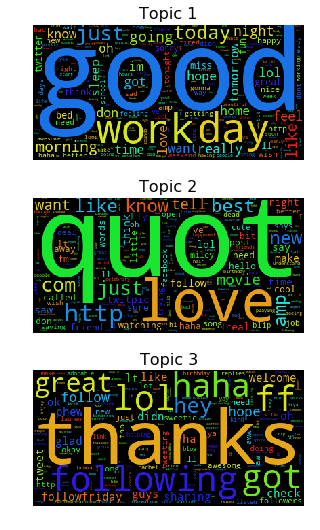

In [11]:
%matplotlib inline

#Visualizse topics.
# Compared with a simple list, from a word cloud we can better understand the relative frequency of all the words.
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

def wdc(*mywords_topic):
    n_row = len(mywords_topic)
    n_col = 1
    plt.figure(figsize=(n_col * 3 * 1.618, n_row * 3))    
    wordcloud = WordCloud()
    
    for index, item in enumerate(mywords_topic, start=1):
        wordcloud.fit_words(item)
        plt.subplot(n_row, n_col, index)
        plt.title('Topic {}'.format(index), size=16)
        plt.imshow(wordcloud)
        plt.axis("off")

wdc(mywords_topic1, mywords_topic2, mywords_topic3)

In [12]:
# Shows how to calcuate the W matrix for new tweets that have been cleaned beforehand. 
# For illustration purpose, these 5 tweets are the first 5 from the corpus used in the analysis.
text_new = preprocessed[0:5]
tfidf_new = vectorizer.transform(text_new)
W_new = nmf.transform(tfidf_new)